<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork32585014-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Regression-based Rating Score Prediction using Embedding Features**


Estimated time needed: **45** minutes


In our previous lab, you have trained a neural network to predict the user-item interactions while simultaneously extracting the user and item embedding features. In the neural network, extends this by using  two embedding vectors as an input into a Neural Network to predict the rating.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module\_4/images/rating_regression.png)


Another way to make rating predictions is to use the embedding as an input to a neural network by aggregating them into a single feature vector as input data `X`.

With the interaction label `Y` such as a rating score or an enrollment mode, we can build our other standalone predictive models to approximate the mapping from `X` to `Y`, as shown in the above flowchart.


In this lab, you will be given the course interaction feature vectors as input data `X` and consider label `Y` as the numerical rating scores. As such, we turn the recommender system into a common regression task and you can apply what you have learned about regression modeling to predict the ratings.


## Objectives


After completing this lab you will be able to:


*   Build regression models to predict ratings using the combined embedding vectors


***


## Prepare and setup lab environment


First install and import required libraries:


In [1]:
# !pip install scikit-learn==1.0.2

In [2]:
# also set a random state
rs = 123

In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

### Load datasets


In [4]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
user_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_embeddings.csv"
item_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_embeddings.csv"

The first dataset is the rating dataset that contains a user-item interaction matrix


In [5]:
rating_df = pd.read_csv(rating_url)

In [6]:
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


As you can see from the above data, the user and item are just ids, let's substitute them by their embedding vectors:


In [7]:
# Load user embeddings
user_emb = pd.read_csv(user_emb_url)
# Load item embeddings
item_emb = pd.read_csv(item_emb_url)

In [8]:
user_emb.head()

,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,0.091464,-0.040247,0.018958,-0.153328,-0.090143,0.082830,-0.058721,0.057929,-0.001472
1,1342067,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,0.104128,-0.034401,0.004011,0.064832,0.165857,-0.004384,0.053257,0.014308,0.056684
2,1990814,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,-0.156026,0.039269,0.042195,0.014695,-0.115989,0.031158,0.102021,-0.020601,0.116488
3,380098,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,-0.060944,0.112384,0.002114,0.090660,-0.068545,0.008967,0.063962,0.052347,0.018072
4,779563,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,-0.019367,-0.031341,0.064896,-0.048158,-0.047309,-0.007544,0.010474,-0.032287,-0.083983


In [9]:
item_emb.head()

,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,0.009657,-0.005238,-0.004098,0.016303,-0.005274,-0.000361,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,CL0101EN,-0.008611,0.028041,0.021899,-0.001465,0.006900,-0.017981,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,ML0120ENv3,0.027439,-0.027649,-0.007484,-0.059451,0.003972,0.020496,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,BD0211EN,0.020163,-0.011972,-0.003714,-0.015548,-0.007540,0.014847,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,DS0101EN,0.006399,0.000492,0.005640,0.009639,-0.005487,-0.000590,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


In [10]:
# Merge user embedding features
user_emb_merged = pd.merge(rating_df, user_emb, how='left', left_on='user', right_on='user').fillna(0)
# Merge course embedding features
merged_df = pd.merge(user_emb_merged, item_emb, how='left', left_on='item', right_on='item').fillna(0)

In [11]:
merged_df.head()

,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,1889878,CC0101EN,3.0,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,...,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,1342067,CL0101EN,3.0,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,...,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,1990814,ML0120ENv3,3.0,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,...,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,380098,BD0211EN,3.0,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,...,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,779563,DS0101EN,3.0,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,...,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


Next, we can combine the user features (the column labels starting with `UFeature` and item features (the column labels starting with `CFeature`. In machine learning, there are many ways to aggregate two feature vectors such as element-wise add, multiply, max/min, average, etc. Here we simply add the two sets of feature columns:


In [12]:
u_feautres = [f"UFeature{i}" for i in range(16)]
c_features = [f"CFeature{i}" for i in range(16)]

user_embeddings = merged_df[u_feautres]
course_embeddings = merged_df[c_features]
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
regression_dataset = user_embeddings + course_embeddings.values
regression_dataset.columns = [f"Feature{i}" for i in range(16)]
regression_dataset['rating'] = ratings
regression_dataset.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.090378,-0.134799,0.083900,0.046534,0.077417,-0.004537,-0.018561,0.079236,-0.024561,0.027359,-0.188823,-0.080762,0.050271,-0.066013,0.058894,-0.007689,3.0
1,0.059437,-0.084740,0.067107,-0.009036,-0.031482,0.050057,0.125847,0.066517,-0.053798,-0.021671,0.064212,0.204660,-0.004188,0.007914,0.027170,0.076114,3.0
2,0.152061,-0.014739,-0.080112,-0.009516,0.024130,0.153802,-0.048061,-0.119888,0.059234,0.060882,0.004244,-0.166000,0.045002,0.057566,-0.022081,0.108929,3.0
3,-0.014707,-0.011257,0.073692,0.054763,-0.050547,-0.020599,0.027146,-0.067012,0.106593,-0.020921,0.106658,-0.092025,0.024436,0.086183,0.029232,0.016287,3.0
4,0.112812,-0.001395,-0.011572,-0.032638,-0.080440,-0.057321,0.064595,-0.020880,-0.048939,0.068486,-0.031359,-0.044577,-0.002381,0.025505,-0.033164,-0.105266,3.0


By now, we have built the input dataset `X` and the output vector `y`:


In [13]:
X = regression_dataset.iloc[:, :-1]
y = regression_dataset.iloc[:, -1]
print(f"Input data shape: {X.shape}, Output data shape: {y.shape}")

Input data shape: (233306, 16), Output data shape: (233306,)


## TASK: Perform regression on the interaction dataset


Now our input data `X` and output `y` are ready, let's build regression models to map X to y and predict ratings.


In [14]:
y.unique()

array([3., 2.])

In an online course system, we may consider the `Completion` mode to be `larger` than the `Audit` mode as a learner needs to put more efforts towards completion.  Now if we treat it as a regression problem,  we would expect the regression model to output ratings ranging from 2.0 to 3.0. To interpret regression model output, we can treat values closer to 2.0 as `Audit` and values closer to 3.0 as `Completion`.


You may use `sklearn` to train and evaluate various regression models.


*TODO: First split dataset into training and testing datasets*


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123
                                                   )


*TODO: Create a basic linear regression model*


In [16]:
regr = linear_model.LinearRegression()


*TODO: Train the basic regression model with training data*


In [17]:
regr.fit(X_train, y_train)



LinearRegression()

*TODO: Evaluate the basic regression model*


In [18]:
### The main evaluation metric is RMSE but you may use other metrics as well
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [-0.12484362  0.06998328  0.03284577  0.05872599  0.08135525  0.04118504
  0.01235966  0.10139207 -0.03473215  0.00484982 -0.01797227  0.02176263
 -0.03364004  0.03169495 -0.05270673  0.07841582]
Mean squared error: 0.04
Coefficient of determination: 0.01


*TODO: Try different regression models such as Ridge, Lasso, ElasticNet and tune their hyperparameters to see which one has the best performance*


In [19]:
from sklearn.linear_model import Ridge, Lasso
regr_ridge = Ridge(alpha=0.01)
regr_ridge.fit(X_train, y_train)

y_pred_ridge = regr_ridge.predict(X_test)

# The coefficients
print("Coefficients: \n", regr_ridge.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_ridge))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_ridge))


Coefficients: 
 [-0.1248423   0.06998251  0.03284545  0.05872538  0.0813544   0.04118455
  0.01235952  0.10139108 -0.03473177  0.00484978 -0.01797205  0.02176238
 -0.03363977  0.03169459 -0.05270602  0.07841508]
Mean squared error: 0.04
Coefficient of determination: 0.01


In [20]:
from sklearn.linear_model import Ridge, Lasso
regr_lasso = Ridge(alpha=1e-5)
regr_lasso.fit(X_train, y_train)

y_pred_lasso = regr_lasso.predict(X_test)

# The coefficients
print("Coefficients: \n", regr_lasso.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_lasso))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_lasso))

Coefficients: 
 [-0.12484362  0.06998328  0.03284577  0.05872599  0.08135525  0.04118504
  0.01235966  0.10139207 -0.03473215  0.00484982 -0.01797227  0.02176263
 -0.03364004  0.03169495 -0.05270673  0.07841582]
Mean squared error: 0.04
Coefficient of determination: 0.01


In [22]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=20, random_state=0)
rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_rfr))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_rfr))

Mean squared error: 0.02
Coefficient of determination: 0.57


C:\Users\kay\anaconda3\envs\ibm\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


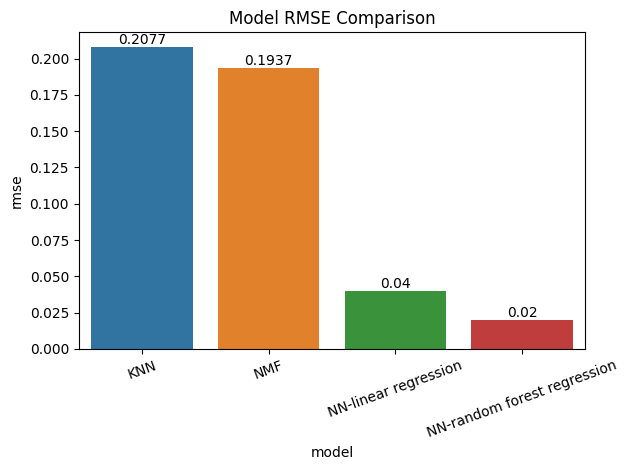

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

rmse_dict = {
    'KNN': [0.2077],
    'NMF': [0.1937],
    'NN-linear regression': [0.04],
    'NN-random forest regression': [0.02]
}

rmse_df = pd.DataFrame.from_dict(rmse_dict)
ax = sns.barplot(data=rmse_df);
ax.set(xlabel='model', ylabel='rmse')
ax.set_title('Model RMSE Comparison')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=20)
plt.tight_layout()

### Summary


In this lab, you have built regression models to predict numerical course ratings using the embedding feature vectors extracted from neural networks. In the next lab, we can treat the prediction problem as a classification problem as rating only has two categorical values so classification can be a more natural problem statement.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork32585014-2022-01-01)


### Other Contributors


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description          |
| ----------------- | ------- | ---------- | --------------------------- |
| 2021-10-25        | 1.0     | Yan        | Created the initial version |


Copyright © 2021 IBM Corporation. All rights reserved.
